# ESTIMACIÓN DE PROBABILIDADES DE INCUMPLIMIENTO EN EL TIEMPO

La obtención de probabilidades de incumplimiento es una parte fundamental en la toma de decisiones en las instituciones de crédito. La probabilidad de incumplimiento se define en general como la probabilidad de que un acreditado no cumpla con las obligaciones de su crédito durante 90 días o más.

## 1. Objetivo:

Análisis de las Probabilidades de Incumplimiento de créditos hipotecarios de Estados Unidos para identificar periodos de crisis mediante el uso de las herramientas vistas en el curso de Análisis Numérico y Computo Científico.

## 2. Datos:

Se utilizará la información de 60 trimestres de 5000 créditos hipotecarios de Estados Unidos tomada de protafolios bursatilizado (RMBSs) a partir del año 2000 (hasta 2015). El proveedor de la base es el International Financial Reasearch (www.internationalfinancialreaserch.org), y se tiene acceso a ella por la adquisición del libro Deep Credit Risk de Daniel Rosch y Harald Scheule, que es la principal fuente de este trabajo.

## 3. Desarrollo:

Importación de las librerías

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import pandas as pd
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import cvxpy as cp

from numpy import linalg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#import utils_pds as utils

import utils_pds2 as utils2

## Las siguientes librerias se usan en caso de correr en AWS
#import boto3 
#import io
#from io import StringIO

In [76]:
#Esta función se utiliza para determinar el número de dígitos de precisión que se imprimen
np.set_printoptions(precision=3, suppress=True)

In [77]:
# Estas líneas son para el caso de correr este código en AWS
### Conexión a la instancia, S3

##Definición de los parámetros para la conexión a S3
#s3client = boto3.client(
#    's3',
#    region_name='us-east-1'
#)

##Asignación del nombre del bucket de S3 y de los datos
#bucketname = "bucketmno2020arenitss"
#file_to_read = "data_t_final.csv"
#Definición objeto de S3 para conectarnos
#fileobj = s3client.get_object(
#    Bucket=bucketname,
#    Key=file_to_read
#    )

### Lectura del archivo, decodificación  y conversión a dataframe
#Lectura del archivo
#filedata = fileobj['Body'].read()

##Decodificación del archivo
#contenido = filedata.decode('utf-8')

##Tipo de archivo
#type(contenido)

##Conversión del archivo a dataframe
#StringData = StringIO(contenido)

##Lectura del archivo
#df = pd.read_csv(StringData)

In [78]:
df = pd.read_csv('/home/oscarperez/Documentos/OSCAR/MNO_2020/datos/data_t_final.csv')

Visualización del archivo

In [79]:
df

id  time  orig_time  first_time  mat_time  res_time  balance_time  \
0          4    25         -2          25       119       NaN      61031.10   
1          4    26         -2          25       119       NaN      60882.42   
2          4    27         -2          25       119       NaN      60729.80   
3          4    28         -2          25       119       NaN      60576.14   
4          4    29         -2          25       119       NaN      60424.39   
...      ...   ...        ...         ...       ...       ...           ...   
62173  49972    52         25          52       145       NaN     180673.24   
62174  49972    53         25          52       145       NaN     179944.95   
62175  49972    54         25          52       145       NaN     179451.81   
62176  49972    55         25          52       145       NaN     178952.48   
62177  49972    56         25          52       145       NaN     178952.48   

         LTV_time  interest_rate_time  rate_time  ...  FICO_orig_time  \
0       33.911009              10.500       5.90  ...             587   
1       34.007232              10.500       5.90  ...             587   
2       34.335349              10.500       5.90  ...             587   
3       34.672545              10.875       5.90  ...             587   
4       34.951639              10.875       5.90  ...             587   
...           ...                 ...        ...  ...             ...   
62173  103.306966               7.500       5.15  ...             708   
62174   95.736862               7.500       5.15  ...             708   
62175   91.867079               7.500       5.15  ...             708   
62176   91.560581               7.500       5.15  ...             708   
62177   90.874242               7.500       5.15  ...             708   

       LTV_orig_time  Interest_Rate_orig_time  state_orig_time  hpi_orig_time  \
0               81.8                     10.5               KY          97.99   
1               81.8                     10.5               KY          97.99   
2               81.8                     10.5               KY          97.99   
3               81.8                     10.5               KY          97.99   
4               81.8                     10.5               KY          97.99   
...              ...                      ...              ...            ...   
62173           79.8                      7.5               AL         226.29   
62174           79.8                      7.5               AL         226.29   
62175           79.8                      7.5               AL         226.29   
62176           79.8                      7.5               AL         226.29   
62177           79.8                      7.5               AL         226.29   

       default_time  payoff_time  status_time  lgd_time  recovery_res  
0                 0            0            0       NaN           NaN  
1                 0            0            0       NaN           NaN  
2                 0            0            0       NaN           NaN  
3                 0            0            0       NaN           NaN  
4                 0            0            0       NaN           NaN  
...             ...          ...          ...       ...           ...  
62173             0            0            0       NaN           NaN  
62174             0            0            0       NaN           NaN  
62175             0            0            0       NaN           NaN  
62176             0            0            0       NaN           NaN  
62177             1            0            1       0.0     178952.48  

[62178 rows x 28 columns]

Quitamos algunos nulos

In [80]:
data = df.dropna(subset=['time', 'default_time','LTV_time', 'FICO_orig_time','state_orig_time']).copy()

## 3.1 Data Engineering

Para esta parte se correrá una regresión logística para revisar qué variables tienen mejor p-value y se usará PCA para reducir dimensionalidad 

Impresión del nombre de las columnas de la base

In [81]:
for col in data.columns: 
    print(col) 

id
time
orig_time
first_time
mat_time
res_time
balance_time
LTV_time
interest_rate_time
rate_time
hpi_time
gdp_time
uer_time
REtype_CO_orig_time
REtype_PU_orig_time
REtype_SF_orig_time
investor_orig_time
balance_orig_time
FICO_orig_time
LTV_orig_time
Interest_Rate_orig_time
state_orig_time
hpi_orig_time
default_time
payoff_time
status_time
lgd_time
recovery_res


### Parte 1. Modelo Ajuste de regresión logística para determinar las variables más explicativas

La variable dependiente del modelo de regresión logística es "default-time" que da información relacionada con el incumplimiento de pago en cada período de tiempo. Es una variable binomial con valores 0 o 1.

La regresión se realiza utilizando una función para modelo lineales generalizados, que admiten varios tipos de familias. Para este ejercicio se tomó un binomial (logśitica) en todas las varibles de la base.

Se hace la regresión con el optimizador visto en clase (la función está cargada en utils_pds):

In [82]:
utils2.estim_prob(data=data, variables = ['default_time', 'balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time'], default = "default_time")

61803
Evaluación de valor óptimo al resolver problema de optimización 13237.629423980561


(array([0.008, 0.008, 0.008, ..., 0.025, 0.023, 0.024]),
 array([-4.889,  0.   , -0.003,  0.19 ,  0.122, -0.013, -0.092, -0.04 ,
         0.066,  0.225,  0.083,  0.213, -0.   , -0.004,  0.022, -0.02 ,
         0.015]))

Revisamos los resultados con la función glm (nótese la simmilitud de los coeficientes:

In [83]:
model_lr = smf.glm('default_time ~ balance_time + LTV_time + interest_rate_time + rate_time + hpi_time + gdp_time + uer_time + REtype_CO_orig_time + REtype_PU_orig_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time', family = sm.families.Binomial(), data = data).fit()

In [84]:
print(model_lr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                61803
Model:                            GLM   Df Residuals:                    61786
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6618.8
Date:                Tue, 08 Dec 2020   Deviance:                       13238.
Time:                        11:39:17   Pearson chi2:                 5.70e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Con relación a los p_values podemos observar que la mayoría de la variables son significativas. Entre las variables más significativas que tienen un impacto positivo sobre el incumplimiento de pago tenemos:
* balance_time.- saldo en el periodo de observación
* interest_rate_time.- tasa de interés en el periodo de observación
* LTV_orig_time.- Loan to Value en el momento de la originación
* hpi_orig_time.- índice de precios de casa en el momento de la originación

Las variables menos significativas son "REtype_CO_orig_time" y "REtype_SF_orig_time, ambas con coeficientes positivos y muy bajos. Estas varaibles son identificadoras del tipo de vivienda.
La variable rate_time, tampoco es significativa

Se aplica el modelo a la base y se guarda en data2

In [85]:
PD_logit_model = pd.DataFrame(model_lr.fittedvalues, columns=['PD_logit_model'])
data2 = pd.merge(data[['default_time','time']],PD_logit_model, right_index=True, left_index=True)

Usamos la función de utils para graficar

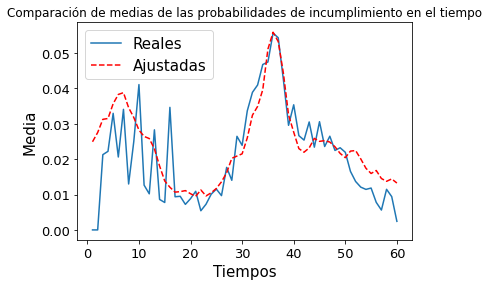

In [86]:
utils2.grafica_medias(data2.PD_logit_model, data2.default_time, data2.time)

Revisamos el ajuste

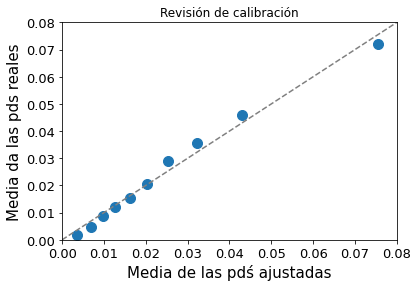

In [87]:
utils2.grafica_ajuste(data2.PD_logit_model, data2.default_time, data2.time)

### Parte 2. Análisis de componentes principales para reducción de dimensionalidad

El analisis de componentes principales se hará para ejemplificar la reduccion de dimensionalidad de la variable "estado".

La variable de estado tiene los siguientes valores:

In [88]:
data.state_orig_time.unique()

array(['KY', 'CO', 'GA', 'TN', 'CA', 'AL', 'NJ', 'DC', 'NC', 'NY', 'FL',
       'WA', 'MD', 'AZ', 'SC', 'MN', 'TX', 'VA', 'OH', 'CT', 'ME', 'MI',
       'WI', 'PA', 'OK', 'NV', 'MA', 'LA', 'IL', 'NE', 'ND', 'MO', 'MT',
       'AR', 'OR', 'NM', 'UT', 'IA', 'SD', 'ID', 'HI', 'RI', 'IN', 'WV',
       'VT', 'MS', 'NH', 'DE', 'KS', 'WY', 'PR', 'AK'], dtype=object)

Una forma de incorporar esta variable es construir dummies con valores de 0 y 1 esto implicaría tener más de 50 variables

Sin embargo podemos reducir dimensionalidad con el análisis de PCA

Primero calcularemos las probabilidades de default de esta vaariable porque es lo que queremos ajustar.


In [89]:
defaultrates_states1 = data.groupby(['time','state_orig_time'])['default_time'].mean().unstack(level=1).add_prefix('defaultrate_').fillna(0).reset_index(drop=False)

In [90]:
# Ahora estandarizamos estos datos  y los ponemos en una matriz
scaler = StandardScaler()
defaultrates_states = scaler.fit_transform(defaultrates_states1)
defaultrates_states

array([[-1.703, -0.13 , -0.353, ..., -0.412, -0.22 , -0.13 ],
       [-1.646, -0.13 , -0.353, ..., -0.412, -0.22 , -0.13 ],
       [-1.588, -0.13 , -0.353, ..., -0.412, -0.22 , -0.13 ],
       ...,
       [ 1.588, -0.13 , -0.353, ..., -0.412, -0.22 , -0.13 ],
       [ 1.646, -0.13 , -0.353, ..., -0.412, -0.22 , -0.13 ],
       [ 1.703, -0.13 , -0.353, ..., -0.412, -0.22 , -0.13 ]])

Hacemos el anaĺisis de componentes principales utilizando el método de potencia y de deflación con la funcion potencia() y deflación() respectivamente de utils.pds.

El análisis se hace con la  matriz defaultrates_states (las funciones obtienen la matriz de varianza covarianzas) 

In [91]:
utils2.potencia(d = defaultrates_states, cor=False, MAX=150)

(array([6.468, 6.578, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
        6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585, 6.585,
      

Ahora con deflación encontramos la segunda componente principal

In [92]:
utils2.deflacion(d = defaultrates_states, cor=False, MAX=150)

(array([1.609, 2.008, 2.242, 2.446, 2.623, 2.754, 2.838, 2.888, 2.916,
        2.932, 2.941, 2.947, 2.95 , 2.953, 2.954, 2.955, 2.956, 2.957,
        2.957, 2.958, 2.958, 2.958, 2.958, 2.958, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
        2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959, 2.959,
      

Generamos la matríz de proyección a partir de los pares autovalor-autovector para la primera y segunda componente para obtener el mapeo a nuestra base

In [93]:
matrix_w2 = np.hstack((utils2.potencia(d = defaultrates_states, cor=False, MAX=150)[1].reshape(53,1),
                      (utils2.deflacion(d = defaultrates_states, cor=False, MAX=150)[1]*-1).reshape(53,1)))

# Proyectamos

Y = defaultrates_states.dot(matrix_w2)

In [94]:
Y

array([[-2.775,  0.018],
       [-2.765,  0.016],
       [-2.609,  1.2  ],
       [-1.863,  0.126],
       [-2.814, -1.478],
       [-3.401, -1.696],
       [-2.514,  3.225],
       [-2.723,  0.898],
       [-2.654,  0.2  ],
       [-1.789, -2.901],
       [-2.686,  0.242],
       [-1.88 , -0.158],
       [-1.195,  1.613],
       [-2.702, -0.505],
       [-2.648,  0.737],
       [ 1.27 ,  7.501],
       [-2.731, -0.281],
       [-1.758, -1.072],
       [-1.031, -2.092],
       [-2.059, -1.076],
       [-0.718,  1.412],
       [-2.124, -0.629],
       [-1.413, -0.471],
       [-2.092,  0.319],
       [-1.086,  0.057],
       [-1.441, -0.499],
       [ 1.512,  0.745],
       [-0.701, -1.569],
       [ 2.818,  0.09 ],
       [ 0.652, -1.181],
       [ 3.046, -1.384],
       [ 5.054, -0.591],
       [ 3.318, -0.14 ],
       [ 3.728,  0.16 ],
       [ 5.961,  4.996],
       [ 7.539, -3.379],
       [ 7.057, -1.025],
       [ 2.911, -0.464],
       [ 1.659, -0.305],
       [ 1.918, -0.95 ],


Ahora usamos las funciones de pyton (PCA()) para comprobar la correspondencia del mapeo a la base

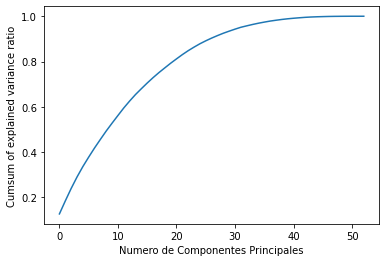

In [95]:
#Graficamos el aporte en varianza de cada componente pricipal adicional
pca=PCA()
pca.fit(defaultrates_states)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Numero de Componentes Principales')
plt.ylabel('Cumsum of explained variance ratio')
plt.show()

Hacemos el mapeo de las componentes

<function matplotlib.pyplot.show(*args, **kw)>

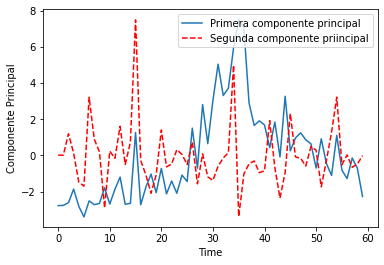

In [96]:
z = pca.transform(defaultrates_states)
plt.xlabel('Time')
plt.ylabel('Componente Principal')
plt.plot(defaultrates_states1.index, z[:,0], alpha =1, label = "Primera componente principal")
plt.plot(defaultrates_states1.index, z[:,1], alpha =1, color = 'red', linestyle = 'dashed', label = "Segunda componente priincipal")
plt.legend(loc='best')
plt.show

Revisamos que el mapeo corresponda con los valores obtenidos con la matriz de proyección (sí coincide)

In [99]:
z = z[:,0:2]
z

array([[-2.775,  0.018],
       [-2.765,  0.016],
       [-2.609,  1.2  ],
       [-1.863,  0.126],
       [-2.814, -1.478],
       [-3.401, -1.696],
       [-2.514,  3.225],
       [-2.723,  0.898],
       [-2.654,  0.2  ],
       [-1.789, -2.901],
       [-2.686,  0.242],
       [-1.88 , -0.158],
       [-1.195,  1.613],
       [-2.702, -0.505],
       [-2.648,  0.737],
       [ 1.27 ,  7.501],
       [-2.731, -0.281],
       [-1.758, -1.072],
       [-1.031, -2.092],
       [-2.059, -1.076],
       [-0.718,  1.412],
       [-2.124, -0.629],
       [-1.413, -0.471],
       [-2.092,  0.319],
       [-1.086,  0.056],
       [-1.441, -0.499],
       [ 1.512,  0.745],
       [-0.701, -1.57 ],
       [ 2.818,  0.088],
       [ 0.652, -1.182],
       [ 3.046, -1.383],
       [ 5.054, -0.591],
       [ 3.318, -0.14 ],
       [ 3.728,  0.159],
       [ 5.961,  4.996],
       [ 7.539, -3.379],
       [ 7.057, -1.024],
       [ 2.911, -0.464],
       [ 1.659, -0.305],
       [ 1.918, -0.951],


Anexamos a la base estos valores

In [100]:
Z = pd.DataFrame(data=z, columns=['PCA1', 'PCA2'])
Z_1 = Z.shift(1).add_suffix('_1')
defaultrates_states2 = pd.concat([defaultrates_states1['time'], Z_1], axis=1).dropna(subset=['PCA1_1']).copy() 
data_con_pca = pd.merge(data, defaultrates_states2, on='time')
data_con_pca

id  time  orig_time  first_time  mat_time  res_time  balance_time  \
0          4    25         -2          25       119       NaN      61031.10   
1          9    25         18          25       138       NaN     127156.28   
2         47    25         19          25       139       NaN     130286.14   
3         13    25         18          25       138       NaN     228957.49   
4         35    25         19          25       139       NaN      78586.07   
...      ...   ...        ...         ...       ...       ...           ...   
61780  37843    15         13          15        73       NaN      44042.18   
61781  38271    15          9          12       129       NaN     638742.73   
61782  38752    15         11          15       131       NaN     333958.30   
61783  39221    15          8          12       128       NaN     471428.67   
61784  40487    15         -4           2        56       NaN      56148.46   

        LTV_time  interest_rate_time  rate_time  ...  Interest_Rate_orig_time  \
0      33.911009              10.500       5.90  ...                   10.500   
1      65.642484               8.730       4.14  ...                    8.730   
2      66.793811               6.930       4.24  ...                    6.930   
3      65.211476               7.560       4.14  ...                    7.560   
4      66.810457               7.030       4.24  ...                    7.030   
...          ...                 ...        ...  ...                      ...   
61780  62.876322               5.125       3.54  ...                    5.125   
61781  57.759641               5.750       4.86  ...                    5.750   
61782  65.428152               6.000       3.83  ...                    6.000   
61783  43.327570               6.250       5.42  ...                    6.250   
61784  40.446417              10.500       5.25  ...                   10.500   

       state_orig_time  hpi_orig_time  default_time  payoff_time  status_time  \
0                   KY          97.99             0            0            0   
1                   GA         186.91             0            0            0   
2                   TN         191.42             0            0            0   
3                   MN         186.91             0            0            0   
4                   TX         191.42             0            0            0   
...                ...            ...           ...          ...          ...   
61780               OK         149.70             0            0            0   
61781               CA         132.76             0            0            0   
61782               MD         142.18             0            0            0   
61783               CA         125.92             0            0            0   
61784               IN          91.31             0            0            0   

       lgd_time  recovery_res    PCA1_1    PCA2_1  
0           NaN           NaN -2.091759  0.319049  
1           NaN           NaN -2.091759  0.319049  
2           NaN           NaN -2.091759  0.319049  
3           NaN           NaN -2.091759  0.319049  
4           NaN           NaN -2.091759  0.319049  
...         ...           ...       ...       ...  
61780       NaN           NaN -2.702444 -0.504520  
61781       NaN           NaN -2.702444 -0.504520  
61782       NaN           NaN -2.702444 -0.504520  
61783       NaN           NaN -2.702444 -0.504520  
61784       NaN           NaN -2.702444 -0.504520  

[61785 rows x 30 columns]

### 3.2 Ajuste final considerando variables discriminadas por regresión logísitica y análisis de PCA

Finalmente hacemos el ajuste final con las variables con mejor p value y adicionamos componentes principales. En primer lugar con el optimizador visto en clase

In [102]:
utils2.estim_prob(data=data_con_pca, variables = ['default_time', 'balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'REtype_PU_orig_time', 'investor_orig_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time', 'PCA1_1', 'PCA2_1'], default = "default_time")

61785
Evaluación de valor óptimo al resolver problema de optimización 13227.950040762656


(array([0.006, 0.019, 0.01 , ..., 0.007, 0.003, 0.009]),
 array([-3.873,  0.   , -0.003,  0.188, -0.015, -0.037, -0.059,  0.16 ,
         0.199, -0.   , -0.004,  0.022, -0.02 ,  0.014,  0.059, -0.02 ]))

Hacemos lo mismo con la función glm, nótese que los coeficientes coinciden

In [104]:
model_lr_pca = smf.glm('default_time ~ balance_time + LTV_time + interest_rate_time + hpi_time + gdp_time + uer_time + REtype_PU_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time+ PCA1_1 + PCA2_1', family = sm.families.Binomial(), data = data_con_pca).fit()
print(model_lr_pca.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                61785
Model:                            GLM   Df Residuals:                    61769
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6614.0
Date:                Tue, 08 Dec 2020   Deviance:                       13228.
Time:                        12:01:28   Pearson chi2:                 5.74e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Se aplica el modelo a la base


In [105]:
PD_logit_model_pca = pd.DataFrame(model_lr_pca.fittedvalues, columns=['PD_logit_model'])
# Hacemos una tabla con default o no default para cada tiempo que estamos estimando y su respectiva probabilidad
data3 = pd.merge(data_con_pca[['default_time','time']],PD_logit_model_pca, right_index=True, left_index=True)

Vemos nuestras graficas de ajuste

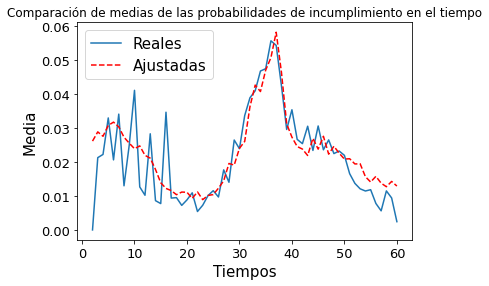

In [106]:
utils2.grafica_medias(data3.PD_logit_model, data3.default_time, data3.time)

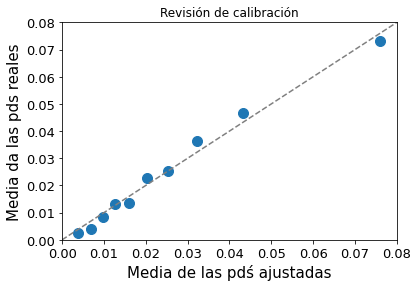

In [107]:
utils2.grafica_ajuste(data3.PD_logit_model, data3.default_time, data3.time)